In [3]:
import sys 
sys.path.append('../')

# Fig S2: application on Mato's data 
Lagator, Mato, et al. "Regulatory network structure determines patterns of  epistasis." Elife 6 (2017): e28921.  

[151, 151]


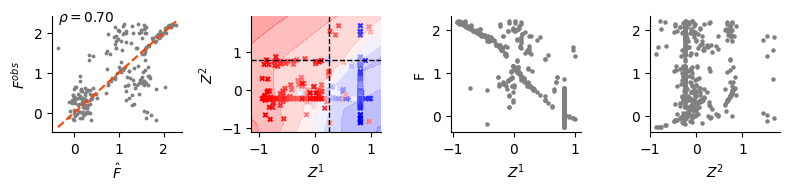

In [3]:
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace, array, meshgrid, exp, diff
from numpy.random import choice
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

data = Data_model("../data/mato.csv", 2)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7))
print(data.nb_val)
model = DLIM(data.nb_val, hid=32, nb_layer=1)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]

losses = train(model, train_data, lr=1e-2, nb_epoch=1000, bsize=64, val_data=val_data, wei_dec=1e-3)
fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
ax.scatter(fit, val_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = pearsonr(fit.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)

min_x, max_x = model.genes[0].min().item(), model.genes[0].max().item()
delta_x = 0.1*(max_x - min_x)
min_y, max_y = model.genes[1].min().item(), model.genes[1].max().item()
delta_y = 0.1*(max_y - min_y)
x_v = linspace(min_x -delta_x, max_x +delta_x, 200)
y_v = linspace(min_y -delta_y, max_y +delta_y, 200)
x_m, y_m = meshgrid(x_v, y_v)
data_m = tensor(array([x_m, y_m]).T).reshape(-1, 2).to(tfloat)
pred_l = model.epi(data_m)[:, [0]].detach().numpy().reshape(200, 200).T
var_l = model.epi(data_m)[:, [1]].detach().numpy().reshape(200, 200).T
bx.contourf(x_m, y_m, pred_l, cmap="bwr", alpha=0.4)
bx.set_xlabel("$Z^1$")
bx.set_ylabel("$Z^2$")

bx.scatter(lat[:, 0], lat[:, 1], c=data[:, -1], s=10, cmap="bwr", marker="x")
bx.plot([min_x -delta_x, max_x +delta_x], [lat[38, 1], lat[38, 1]], c="black", linewidth=1, linestyle="--")
bx.plot([lat[38, 0], lat[38, 0]], [min_y -delta_y, max_y +delta_y], c="black", linewidth=1, linestyle="--")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$Z^1$")
dx.set_xlabel("$Z^2$")

plt.tight_layout()
plt.savefig("../img/fit_mato.png", dpi=300, transparent=True)
plt.show()


# Fig S3: tune different hyper parameters

### step1: run code in SI_3_simulated_data.py by running:
- python SI_3_simulated_data.py -l 0
- python SI_3_simulated_data.py -l 1
- python SI_3_simulated_data.py -l 2
- python SI_3_simulated_data.py -l 3
### step2: plot the results

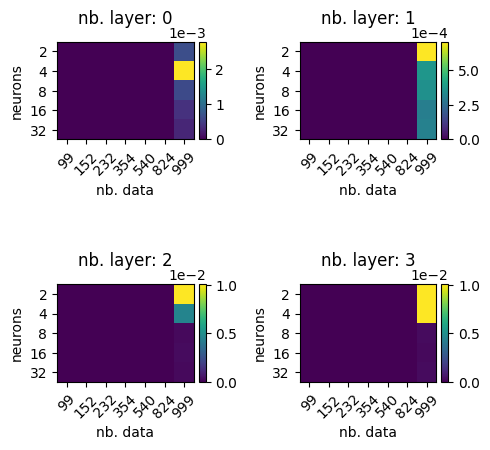

In [155]:
# get the results 
import joblib 
import numpy as np 
from numpy import logspace
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace
from numpy.random import choice
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
neuros_l = [2, 4, 8, 16, 32] 
layers_l = [0, 1, 2, 3]
data = Data_model("../data/data_env_1.csv", 2)
fix, axes = plt.subplots(2, len(layers_l)//2, figsize=(2.5*2, 2.5*2))
val_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.3)) 
train_full_id = [i for i in range(data.data.shape[0]) if i not in val_id]
train_full_data = data[train_full_id, :]
val_frac = logspace(-1, 0.1, num=7) 
size_l = []
for frac in val_frac:
    if frac > 1:
        frac = 1
    size_l += [int(len(train_full_id)*frac)]
for id_layer, layer in enumerate(layers_l):
    ip1, ip2 = id_layer//2, id_layer%2
    results = joblib.load('results/si_1_parameters_' + str(layer) + '.joblib')
    val_frac = set(np.array(list(results.keys()))[:,0]) 
    for ip, frac in enumerate(val_frac): 
        res = np.zeros((len(val_frac), len(neuros_l)))
        for id_neuro, neuro in enumerate(neuros_l): 
            val = np.mean(np.array(results[(frac, neuro, layer)])[:,-1]) 
            res[ip,id_neuro] = val 
    axes[ip1, ip2].set_yticks([0, 1, 2, 3, 4], neuros_l, rotation=0)
    im = axes[ip1, ip2].matshow(res.T)
    axes[ip1, ip2].set_xticks(list(np.arange(len(size_l))), size_l, rotation=45)
    axes[ip1, ip2].xaxis.set_ticks_position('bottom')
    axes[ip1, ip2].set_ylabel('neurons')
    axes[ip1, ip2].set_xlabel('nb. data')
    axes[ip1, ip2].set_title(f'nb. layer: {layer}', y = 1.1)
    divider = make_axes_locatable(axes[ip1, ip2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.formatter.set_powerlimits((0, 0))
plt.tight_layout()
plt.savefig("../fig/S3.png", dpi=300, transparent=True)
plt.show()
        

In [151]:
len(train_full_id)

995

In [27]:
for ip, frac in enumerate(val_frac): 
    print(frac)

0.09999999999999999
0.1525222956539019
0.23263050671536262
0.3548133892335755
0.5411695265464637
0.8254041852680185
1.258925411794167


# Fig S5: comparison between different algroithm 

### step1: run SI_code/S5_comparison_alg.py 
### step2: plot here 

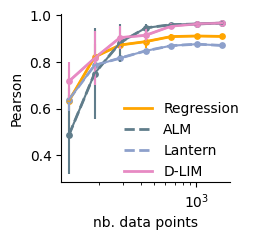

In [8]:
from src.model import DLIM, Regression
from src.utils import Data_model, train, train_reg
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from numpy import mean, logspace, std
from numpy.random import choice, seed
import matplotlib.pyplot as plt
from multiprocessing import Pool
from src.sim_data import Simulated
# get result 
import joblib
import sys 
sys.path.append('../')
result_latern = joblib.load('results/lantern_result.joblib')
result_nn_reg = joblib.load('results/nn_reg.joblib')

data = Data_model("../data/data_epis_1.csv", 2)
res_w, res_c, res_lan, res_lan2 = [], [], [], []
val_frac = logspace(-1, 0.1, num=7)
for id in range(7):
    frac1 = list(result_nn_reg.keys())[id]
    frac2 = list(result_latern.keys())[id]
    res_w += [result_nn_reg[frac1]['nn']]
    res_c += [result_nn_reg[frac1]['reg']]
    res_lan += [result_nn_reg[frac1]['add_lan']]
    res_lan2 += [result_latern[frac2]]

fig, ax = plt.subplots(figsize=(2.5, 2.5))
color1 = '#e78ac3'  # pink
color2 = '#ffa500'  # modern orange
color3 = '#607d8b'  # light gray-blue
color4 = '#8da0cb' # 

ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_c], c=color2, lw=2, label="Regression")
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_c], c=color2, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_c], yerr=[std(el) for el in res_c], c=color2)

ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_lan], c=color3, lw=2, label="ALM", linestyle = 'dashed')
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_lan], c=color3, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_lan], yerr=[std(el) for el in res_lan], c=color3)

ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_lan2], c=color4, lw=2, label="Lantern", linestyle = 'dashed')
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_lan2], c=color4, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_lan2], yerr=[std(el) for el in res_lan2], c=color4)

ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_w], c=color1, lw=2, label="D-LIM")
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_w], c=color1, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_w], yerr=[std(el) for el in res_w], c=color1)

ax.set_xscale("log")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.set_ylabel("Pearson")
ax.set_xlabel("nb. data points")
ax.legend(frameon=False, bbox_to_anchor=(0.3, 0.3, 0.25, 0.25))
plt.tight_layout()
plt.savefig("../fig/S5.png", dpi=300, transparent=True)
plt.show()

# Fig S6: landscape complexity comparison 

### step1: run SI_code/SI_6_simulated_data.py to get latent variables after several run
### step2: plot here 

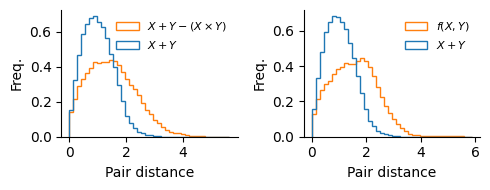

In [10]:
import matplotlib.pyplot as plt
import joblib 
import numpy as np 
result = joblib.load( 'results/simulated_data.joblib')
fig, bx = plt.subplots(1, 2, figsize=(2.5*2, 2.0))
for id, flag in enumerate(['comp', 'exp']):
    tmp1 = np.concatenate(np.array(result[flag]), axis = 1) 
    tmp2 = np.concatenate(np.array(result['add']), axis = 1) 
    tmp = list(tmp2) + list(tmp1)
    if flag == 'comp':
        lab = "$X+Y - (X \\times Y)$"
    elif flag == 'quad':
        lab = "$X \\times Y$"
    elif flag == 'hat':
        lab = "$sin(X^2 + Y^2)$"
    elif flag == 'saddle':
        lab = "$X^2 - Y^2$"
    elif flag == 'exp':
        lab = "$f(X,Y)$"
    for el in ["top", "right"]:
        bx[id].spines[el].set_visible(False)
    bx[id].hist(tmp, density=True, histtype="step", label=["$X+Y$", lab], bins=40)

    bx[id].legend(frameon=False, fontsize=8)
    bx[id].set_xlabel("Pair distance", fontsize=10)
    bx[id].set_ylabel("Freq.", fontsize=10)
plt.tight_layout()
plt.savefig("../fig/S6.png", dpi=300, transparent=True)
plt.show()


# Fig S7: simulated data extrapolation 

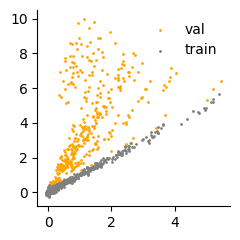

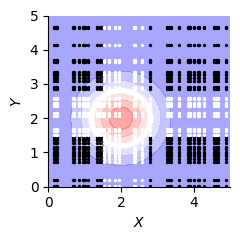

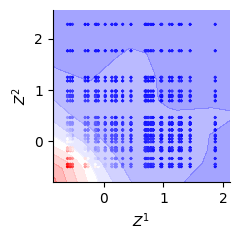

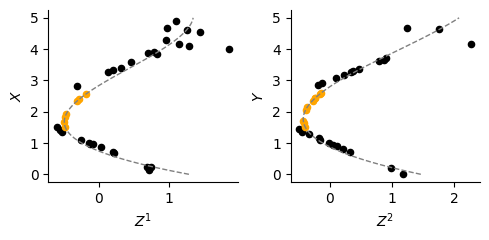

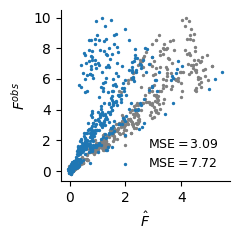

In [4]:
from torch import tensor, cat
from src.model import DLIM
from src.utils import Data_model, train
from src.sim_data import Simulated
from numpy import mean
from numpy.random import choice, shuffle, sample
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import matplotlib.patches as mpatches

type_f = "exp"
nb_state = 36
data = Simulated(nb_state, type_f)

model = DLIM(2, nb_state=nb_state, hid=32, nb_layer=1)

thres = 1.2
A_id = [i for i, el  in enumerate(data.A) if el >= 2.7 or el < 1.5]
B_id = [i for i, el  in enumerate(data.B) if el >= 2.7 or el < 1.5]
nA_id = [i for i, el  in enumerate(data.A) if i not in A_id]
nB_id = [i for i, el  in enumerate(data.B) if i not in B_id]
train_id = [i for i, el  in enumerate(data.data) if el[0] in A_id and el[1] in B_id]
len(train_id)
train_data = data[train_id, :]
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
val_data = data[val_id, :]

losses = train(model, train_data, lr=1e-2, nb_epoch=300, bsize=64, wei_dec=1e-3, val_data=val_data)
train_l, val_l = zip(*losses)


fit_v, vari_v, lat_v = model(val_data[:, :-1].long(), detach=True)
fit_t, var_t, lat_t = model(train_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.scatter(fit_v, val_data[:, [-1]], s=1, label="val", c="orange")
ax.scatter(fit_t, train_data[:, [-1]], s=1, label="train", c="grey")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"../img/{type_f}_fit_quality.png", dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
data.plot(ax)
ax.scatter(data.A[data.data[train_id, 0].long()], data.B[data.data[train_id, 1].long()], s=2, marker="o", c="black")
ax.scatter(data.A[data.data[val_id, 0].long()], data.B[data.data[val_id, 1].long()], s=2, marker="o", c="white")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig(f"../img/{type_f}_land_data.png", dpi=300, transparent=True)
plt.show()

fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
model.plot(bx)
bx.scatter(model.genes[0][data.data[train_id, 0].long()].detach(),
           model.genes[1][data.data[train_id, 1].long()].detach(),
           c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
# bx.set_aspect(1)
plt.tight_layout()
plt.savefig(f"../img/{type_f}_land_pred.png", dpi=300, transparent=True)
plt.show()

model.train_convert(A_id, data.A[A_id], 0)
model.train_convert(B_id, data.B[B_id], 1)
model.update_emb(nA_id, data.A[nA_id], 0)
model.update_emb(nB_id, data.B[nB_id], 1)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(5, 2.5))
ax.scatter(model.genes[0][A_id].detach(), data.A[A_id], c="black", s=20)
ax.scatter(model.genes[0][nA_id].detach(), data.A[nA_id], c="orange", s=20)
ax.plot(np.polyval(model.conversion[0], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
bx.scatter(model.genes[1][B_id].detach(), data.B[B_id], c="black", s=20)
bx.scatter(model.genes[1][nB_id].detach(), data.B[nB_id], c="orange", s=20)
bx.plot(np.polyval(model.conversion[1], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
ax.set_ylabel("$X$")
ax.set_xlabel("$Z^1$")
bx.set_ylabel("$Y$")
bx.set_xlabel("$Z^2$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig(f"../img/{type_f}_cor_bio.png", dpi=300, transparent=True)
plt.show()

fit_n, var_n, lat_n = model(val_data[:, :-1].long(), detach=True)
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score = ((fit_n.flatten() - val_data[:, [-1]].flatten())**2).mean()
score_v = ((fit_v.flatten() - val_data[:, [-1]].flatten())**2).mean()

ax.scatter(fit_n, val_data[:, [-1]], s=2, c="grey", label=f"MSE$={score:.2f}$")
ax.scatter(fit_v, val_data[:, [-1]], s=2, c="C0", label=f"MSE$={score_v:.2f}$")

ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False, ncol=1, fontsize=9)
plt.tight_layout()
plt.savefig(f"../img/{type_f}new_fit.svg", dpi=300, transparent=True)
plt.show()

# Fig S8: performance improvement by extrapolation 

1.1460229385697454
6.750884487037114


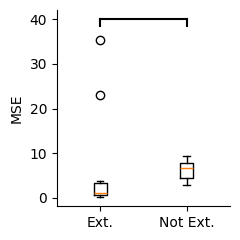

In [18]:
from torch import tensor, cat
from src.model import DLIM
from src.utils import Data_model, train
from src.sim_data import Simulated
from numpy import mean
from numpy.random import choice, shuffle, sample
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr, ttest_ind


def test_score(model, val_data, A_id, B_id, nA_id, nB_id):
    fit_v, vari_v, lat_v = model(val_data[:, :-1].long(), detach=True)

    model.train_convert(A_id, data.A[A_id], 0)
    model.train_convert(B_id, data.B[B_id], 1)
    model.update_emb(nA_id, data.A[nA_id], 0)
    model.update_emb(nB_id, data.B[nB_id], 1)

    fit_n, var_n, lat_n = model(val_data[:, :-1].long(), detach=True)
    score = ((fit_n.flatten() - val_data[:, [-1]].flatten())**2).mean()
    score_v = ((fit_v.flatten() - val_data[:, [-1]].flatten())**2).mean()
    return score, score_v


type_f = "bio"
nb_var = 30
rho_l, rho_lv = [], []
for i in range(10):
    data = Simulated(nb_var, type_f)

    model = DLIM(2, nb_state=nb_var, hid=32, nb_layer=1)

    thres = 1.2
    A_id = [i for i, el  in enumerate(data.A) if el >= thres]
    B_id = [i for i, el  in enumerate(data.B) if el >= thres]
    nA_id = [i for i, el  in enumerate(data.A) if i not in A_id]
    nB_id = [i for i, el  in enumerate(data.B) if i not in B_id]
    train_id = [i for i, el  in enumerate(data.data) if el[0] in A_id and el[1] in B_id]
    train_data = data[train_id, :]
    val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
    val_data = data[val_id, :]

    losses = train(model, train_data, lr=1e-2, nb_epoch=400, bsize=64, wei_dec=1e-3, val_data=val_data)
    score, score_v = test_score(model, val_data, A_id, B_id, nA_id, nB_id)
    rho_l += [score]
    rho_lv += [score_v]

# remove the outliers where the training did not converged
print(np.median([v for v in rho_l]))
print(np.median([v for v in rho_lv]))
test = ttest_ind(rho_l, rho_lv, equal_var=False)
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))

# Plotting the boxplots
ax.boxplot([rho_l, rho_lv], positions=[1, 2], labels=["Ext.", "Not Ext."])

max_height = max(max(rho_l), max(rho_lv)) * 1.1
y, h, col = max_height * 1.03, max_height * 0.03, 'black'  # y position and height for the line

# Main line
x1, x2 = 1, 2  # x positions for the boxplots
ax.plot([x1, x2], [y, y], c=col)
ax.plot([x1, x1], [y - h*1.3, y], c=col)
ax.plot([x2, x2], [y - h*1.3, y], c=col)

# Determining the maximum height for the line
ax.text(1.5, max_height * 1.1, "***" if test.pvalue < 0.05 else "", ha='center', va='bottom')
ax.set_ylabel("MSE")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig("../fig/S8.png", dpi=300, transparent=True)
plt.show()

# Fig S9: pair modeling on RNA

In [ ]:
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace, array, meshgrid
from numpy.random import choice
import numpy as np
from torch import tensor, float32 as tfloat, cat as tcat
import matplotlib.pyplot as plt

data = Data_model("../data/rand_seq_paired.dat", 91)
model = DLIM(91, nb_state=16, hid=64, nb_layer=1)

train_data = data

losses = train(model, train_data, lr=1e-2, nb_epoch=400, bsize=64, wei_dec=1e-3)
train_l, val_l = zip(*losses)
plt.plot(train_l)
plt.show()

fit, var, _ = model(data[:, :-1].int())
fit, var = fit.detach(), var.detach()

fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2))
ax.scatter(fit, data[:, [-1]], s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("Prediction")
ax.set_ylabel("Energy")
cov_mat = np.zeros((14, 14))
ppi = 0

for i in range(14):
    for j in range(14):
        if i > j:
            lat = tcat((model.genes[ppi], model.genes[ppi]), dim=1)
            differences = lat[:, np.newaxis, :] - lat[np.newaxis, :, :]
            distances = np.linalg.norm(differences.detach().numpy(), axis=2)
            cov_mat[i, j] = distances.var()
            cov_mat[j, i] = cov_mat[i, j]
            ppi += 1

bx.imshow((cov_mat))
bx.set_xlabel("Positions")
bx.set_ylabel("Positions")
bx.set_xticks([0, 9])
bx.set_yticks([0, 9])
bx.set_xticklabels([1, 10])
bx.set_yticklabels([1, 10])
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig("../fig/S9.png", dpi=300, transparent=True)
plt.show()

# Fig S10: observation of variance on Kemble data 

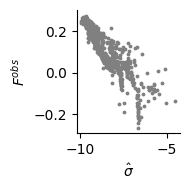

In [16]:
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace
from numpy.random import choice
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Here you can change the path into your file's path 
file_name = "../data/data_env_1.csv"
nb_gene = 2 
data = Data_model(file_name, nb_gene)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.2))
model = DLIM(nb_gene, nb_state=37, hid=16, nb_layer=0)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

losses = train(model, train_data, lr=1e-2, nb_epoch=500, bsize=16, val_data=val_data, wei_dec=1e-2)
train_l, val_l = zip(*losses)
# plot the training and validation curve 

fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fit_a, var_a, lat_a = model(data[:, :-1].long(), detach=True)


fig, ax = plt.subplots(1, figsize=(2, 2), sharey=True)
ax.scatter(var_a.log(), data[:, [-1]], s=3, c="grey")
ax.set_xlabel("$\\hat{\\sigma}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig("../fig/S10.png", dpi=300, transparent=True)
plt.show()

## Fig.S11: how weight change the regularization 

### step1: run code in SI_11_regularization.py firstly to get the results after several running 
### step2: plot 

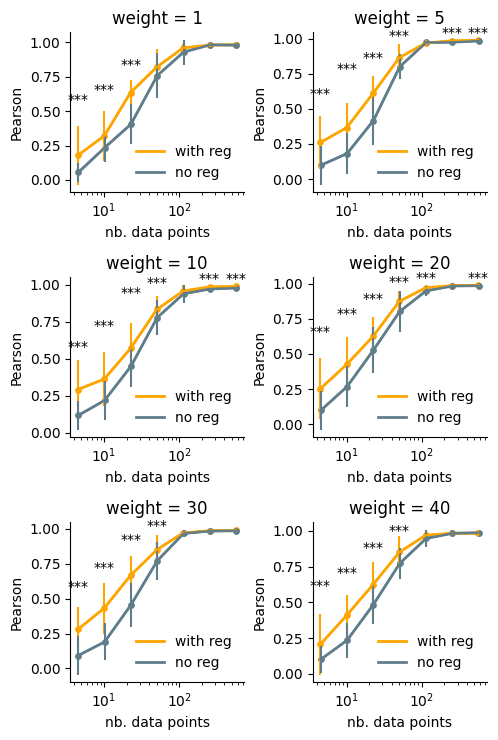

In [5]:
import joblib 
from numpy import logspace, mean, std 
from scipy.stats import pearsonr, spearmanr, ttest_ind
import numpy as np 
weight = [1, 5, 10, 20, 30, 40]
file = 'results/regulization_res_run.joblib'
results_all = joblib.load(file)

fig, ax = plt.subplots(3, 2, figsize=(2.5*2, 2.5*3))
for id in range(len(weight)):
    id1, id2 = id//2 , id%2
    results = results_all[weight[id]]
    nn_res, reg_res = [], []
    for key in results:
        nn_res += [results[key]['reg']]
        reg_res += [results[key]['no']]
        val_frac = logspace(-2, 0.1, num=7)
        val_frac = val_frac * data.data.shape[0]
        color1 = '#ffa500'  # modern orange
        color2 = '#607d8b'  # light gray-blue
    ax[id1, id2].plot(val_frac, [mean(el) for el in nn_res], c=color1, lw=2, label="with reg")
    ax[id1, id2].plot(val_frac + val_frac*0.01, [mean(el) for el in reg_res], c=color2, lw=2, label="no reg")
    ax[id1, id2].scatter(val_frac, [mean(el) for el in nn_res], c=color1, s=15)
    ax[id1, id2].scatter(val_frac + val_frac*0.01, [mean(el) for el in reg_res], c=color2, s=15)
    ax[id1, id2].errorbar(val_frac, [mean(el) for el in nn_res], yerr=[std(el) for el in nn_res], c=color1)
    ax[id1, id2].errorbar(val_frac + val_frac*0.01, [mean(el) for el in reg_res], yerr=[std(el) for el in reg_res], c=color2)
    ax[id1, id2].set_xscale("log")
    for el in ["top", "right"]:
        ax[id1, id2].spines[el].set_visible(False)
    ax[id1, id2].set_ylabel("Pearson")
    ax[id1, id2].set_xlabel("nb. data points")
    ax[id1, id2].set_title(f"weight = {weight[id]}")
    ax[id1, id2].legend(frameon=False)
    for i in range(7):
        rho_l, rho_lv = np.array(nn_res)[i,:], np.array(reg_res)[i,:]
        test = ttest_ind(rho_l, rho_lv, equal_var=False)
        max_height = max(max(rho_l), max(rho_lv)) 
        # Determining the maximum height for the line
        ax[id1, id2].text(val_frac[i], max_height, "***" if test.pvalue < 0.05 else "", ha='center', va='bottom')
plt.tight_layout()
plt.savefig("../fig/S11.png", dpi=300, transparent=True)
plt.show()

# Simulation on genes enzyme network

## step1: generate data 

In [229]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dz/dt
def model(z,t,I, arg):
    A = z[0]
    B = z[1]
    C = z[2]
    dAdt = I * arg[0] * (1-A)/(1-A+arg[1]) - arg[2]*arg[3]*A/(A+arg[4])
    dBdt = A * arg[5] * (1-B)/(1-B+arg[6]) - arg[7]*arg[8]*B/(B+arg[9])
    dCdt = A * arg[10] * (1-C)/(1-C+arg[11]) - B*arg[12]*C/(C+arg[13])
    dzdt = [dAdt,dBdt, dCdt]
    return dzdt


def reaction(arg, plot =False):
    # initial condition
    z0 = [0,0,0]

    # number of time points
    n = 400

    # time points
    t_1 = n//2
    t = np.linspace(0,800,n)

    # step input
    u = np.zeros(n)
    # change to 2.0 at time = 5.0
    u[:t_1] = 0.1
    u[t_1:] = 1.0

    # store solution
    A = np.empty_like(t)
    B = np.empty_like(t)
    C = np.empty_like(t)
    # record initial conditions
    A[0] = z0[0]
    B[0] = z0[1]
    C[0] = z0[2]
    z0 = [0,0,0]
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        z = odeint(model,z0,tspan,args=(u[i],arg,))
        # store solution for plotting
        A[i] = z[1][0]
        B[i] = z[1][1]
        C[i] = z[1][2]
        # next initial condition
        z0 = z[1]
    # plot results
    if plot:
        plt.figure(figsize=(4, 2.5))
        plt.plot(t,u,'g:',label='I(t)')
        plt.plot(t,A,'b-',label='A(t)')
        plt.plot(t,B,'r--',label='B(t)')
        plt.plot(t,C, 'k--',label='C(t)')
        plt.ylabel('values')
        plt.xlabel('time')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig('../fig/SI_simulated_output.png', dpi = 300, transparent = True)
        plt.show()
    return (np.max(C) - C[t_1])/C[t_1] 

# simulate data 
from tqdm import tqdm 
simulate_data = False 
if simulate_data: 
    nb_var = 20
    var1 = np.random.uniform(8, 10, size=nb_var)
    var2 = np.random.uniform(9, 10, size=nb_var)
    var3 = np.random.uniform(0.1, 3, size=nb_var)
    p1, p2, p3 = np.meshgrid(var1, var2, var3)
    p1, p2, p3 = p1.flatten(), p2.flatten(), p3.flatten()
    arg = np.array([ 8.64, 76.58,  1.        ,  9, 74.27 ,
            0.3, 84.34,  1.        ,  4.09, 90.30,
            6.27, 37.21,  2.06, 14.35])
    with open('data/simualted_enzyme.csv', 'w') as f:
        for id in tqdm(range(len(p1))):
            arg[0], arg[3], arg[5] =  p1[id], p2[id], p3[id]
            fit, fit_2 = reaction(arg, plot=False)
            # print(fit, fit_2)
            f.write(f'{p1[id]},{p2[id]},{p3[id]}')
            f.write(f',{str(fit)}')
            f.write('\n')

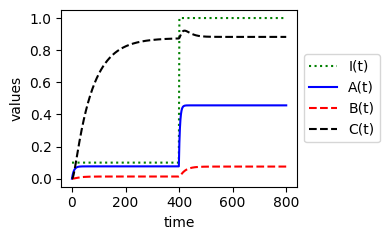

0.05164226996094289

In [232]:
arg = np.array([ 8.64, 76.58,  1.        ,  9.97, 74.27 ,
            0.69, 84.34,  1.        ,  4.09, 90.30,
            6.27, 37.21,  2.06, 14.35])
reaction(arg, plot =True)

## step 2: train the model 

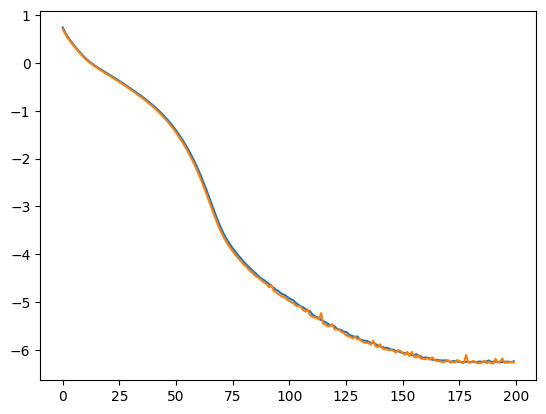

/tmp/ipykernel_8354/2258728762.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


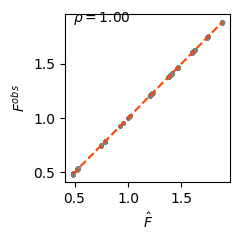

In [214]:
import pandas as pd 
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace
import numpy as np 
from numpy.random import choice, uniform, normal
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from src.plot_figure import plot_figure 
file_name = "../data/simualted_enzyme.csv"
nb_gene = 3 
data = Data_model(file_name, nb_gene) 
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.5))
model = DLIM(nb_gene, nb_state=20, hid=8, nb_layer=1)
train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

losses = train(model, train_data, lr=1e-4, nb_epoch=200, bsize=32, val_data=val_data, wei_dec=1e-3)
train_l, val_l = zip(*losses)

# plot the training and validation curve 
plt.plot(train_l)
plt.plot(val_l)
plt.show()


from sklearn.metrics import r2_score
fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax.scatter(fit, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = pearsonr(fit.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")
fig.tight_layout()
fig.savefig('../fig/S14.png', dpi = 300, transparent=True)
fig.show()



# step3: visualization on landscape 

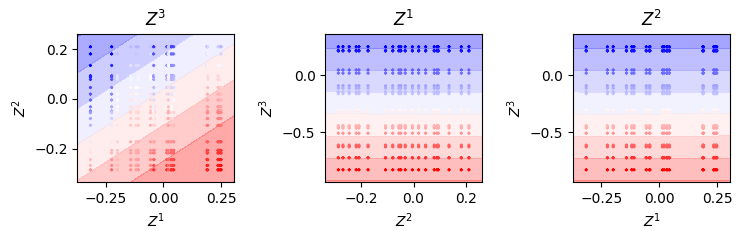

In [216]:
plot_figure(model, id_gene = 4, save_name='../fig/S15.png', data = data)

/tmp/ipykernel_8354/4262105341.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


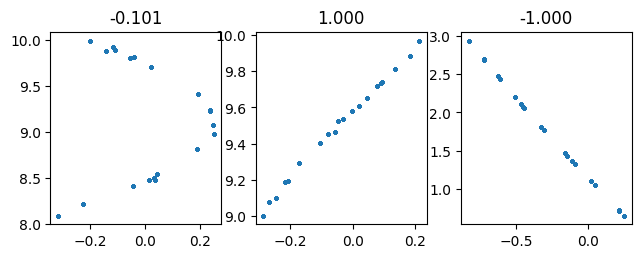

In [217]:
from scipy.stats import spearmanr
data = Data_model(file_name, nb_gene)  
fit, var, lat = model.forward(data[:, :-1].long(), detach=True)
data_t = pd.read_csv(file_name, header=None)
id = 1
fig,ax = plt.subplots(1,3, figsize = (2.5*3, 2.5))
for id in range(3):
    ax[id].scatter(lat[:,id], data_t.loc[:,id], s = 3)
    ax[id].set_title(f'{spearmanr(lat[:,id], data_t.loc[:,id])[0]:0.3f}')

fig.savefig('../fig/S17.png', dpi = 300, transparent=True)

fig.show()

# Simulation on allosteric model 

In [3]:
import sys 
sys.path.append('../')
import pandas as pd 
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace
import numpy as np 
from numpy.random import choice, uniform, normal
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from src.allostery import ec50, delta_eps_AI_0, K_A_0, delta_eps_RA_0
from scipy.stats import spearmanr, pearsonr
from src.plot_figure import plot_figure  

## step1: get simulated data 

In [218]:
# data preprocess 
# simulate data 
nb_var = 20
K_A = normal(K_A_0, 1.5, size=nb_var)
shift_IA = normal(delta_eps_AI_0, 1.5, size=nb_var)
shift_RA = normal(delta_eps_RA_0, 1.5, size=nb_var)
p1, p2, p3 = np.meshgrid(K_A, shift_IA, shift_RA)
p1, p2, p3 = p1.flatten(), p2.flatten(), p3.flatten()
tmp = []
for id in range(len(p1)):
    fit = ec50(K_A=p1[id], delta_eps_AI=p2[id], delta_eps_RA=p3[id])
    tmp += [fit]
df = {
    'K_A': p1,
    'shift_IA': p2,
    'shift_RA': p3,
    'fit': tmp 
}

df = pd.DataFrame.from_dict(df)
df.head(5)
df.to_csv("../data/processed/allostery.csv", header=None, index=False)


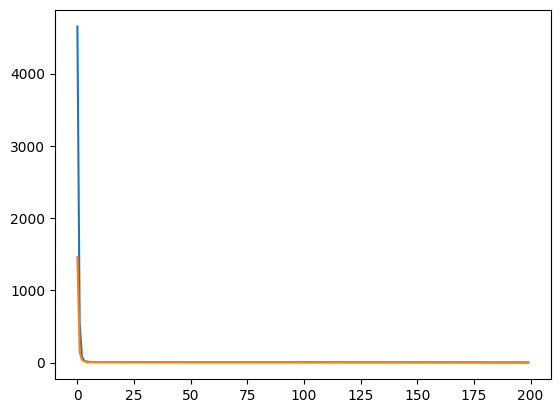

/tmp/ipykernel_15879/779739280.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


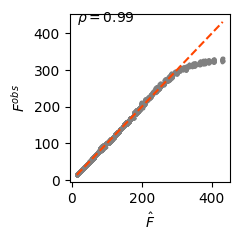

In [4]:
file_name = "../data/processed/allostery.csv"
nb_gene = 3 
nb_var = 20 
data = Data_model(file_name, nb_gene) 
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.2))
model = DLIM(nb_gene, nb_state=nb_var, hid=32, nb_layer=2)
train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

losses = train(model, train_data, lr=1e-3, nb_epoch = 200, bsize=32, val_data=val_data, wei_dec=1e-2)
train_l, val_l = zip(*losses)

# plot the training and validation curve 
plt.plot(train_l)
plt.plot(val_l)
plt.show()



fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax.scatter(fit, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = pearsonr(fit.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")
fig.tight_layout()
fig.savefig('../fig/S12.png', dpi = 300, transparent=True)
fig.show()


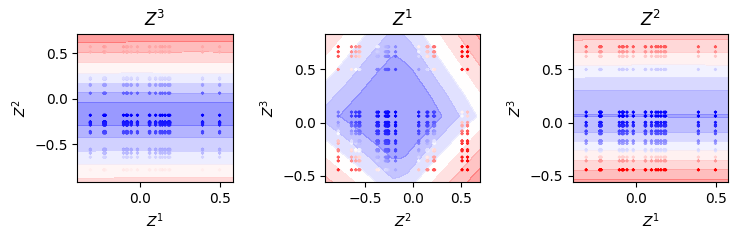

In [5]:
plot_figure(model, id_gene = 6, save_name = '../fig/S13.png', data= data)

/tmp/ipykernel_15879/897624531.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


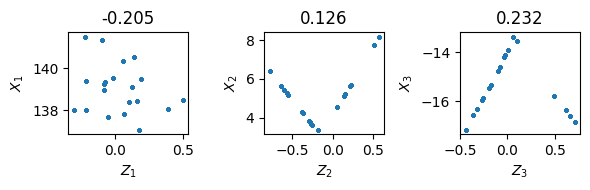

In [6]:
fit, var, lat = model.forward(data[:, :-1].long(), detach=True)
data_t = pd.read_csv(file_name, header=None)
id = 1
fig,ax = plt.subplots(1,3, figsize = (6, 2))
for id in range(3):
    ax[id].scatter(lat[:,id], data_t.loc[:,id], s = 3)
    ax[id].set_title(f'{spearmanr(lat[:,id], data_t.loc[:,id])[0]:0.3f}')
    if id == 0:
        x_label = '$Z_1$'
        y_label = '$X_1$'
    if id == 1:
        x_label = '$Z_2$'
        y_label = '$X_2$'
    if id == 2:
        x_label = '$Z_3$'
        y_label = '$X_3$'
    ax[id].set_xlabel(x_label)
    ax[id].set_ylabel(y_label)
fig.tight_layout()
fig.savefig('../fig/S16.png', dpi = 300, transparent=True)
fig.show()